### Retrieval-Augmented Generation (RAG)

The following notebook is a simple-to-use template for developing RAG systems powered by Ollama, OpenAI API or other LLM model providers. It requires minimal editing of path values, and the LLM provider/model(s).

Refer to the code comments and follow any provided instructions to complete required placeholders prior to running each cell.

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain.tools import tool
from langchain_ollama import OllamaEmbeddings, ChatOllama
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQA
from langchain_community.vectorstores import FAISS
import os

#### States

In [16]:
class ChatbotState(TypedDict):
    messages: Annotated[list[str], add_messages]

#### LLMs

In [ ]:
# main chat model (CHANGE TO APPROPRIATE API IF OLLAMA IS NOT USED)
llm = ChatOllama(
    # ADD YOUR MODEL NAME
    model="qwen3:8b",
    temperature=0.3,
    # extract_reasoning=True,
    num_ctx=4096,
    verbose=True
)

# retrieval model
rag_llm = ChatOllama(
    # ADD YOUR MODEL NAME
    model="gemma3:12b", 
    temperature=0.2,
    num_ctx=4096,
    verbose=True
)

#### LLM tools

In [ ]:
@tool
def expert(query: str) -> dict:
    '''
    Expert tool is trained to answer technical questions and retrieve answers from any user supplied attachments.
    Use this tool to assist with user enquiries.
    The tool will require a cohesive and concise question as input to return the results including the source of retrieved information.
    '''
    
    qa = RetrievalQA.from_chain_type(
            rag_llm,
            retriever=retriever,
            return_source_documents=True
    )

    return qa.invoke({"query": query})

In [ ]:
tools = [expert]
llm = llm.bind_tools(tools)

#### Load, split and index documents

In [ ]:
pdf_path = "example_pdf/s41586-023-06127-z-1.pdf"
index_path = "example_index/" + "s41586-023-06127-z-1"
os.makedirs(index_path, exist_ok=True)
# ADD YOUR EMBEDDING MODEL
embeddings = OllamaEmbeddings(model="embeddinggemma:300m")

##### Index

In [21]:
doc = PyMuPDFLoader(file_path=pdf_path, images_parser=rag_llm).load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(doc)
vector_store = FAISS.from_documents(all_splits, embeddings)
vector_store.save_local(index_path)

##### Or load an existing index

In [22]:
try:
    if os.listdir(index_path):
        vector_store = FAISS.load_local(index_path, embeddings, allow_dangerous_deserialization=True)
except:
    print("------ERROR - INDEX NOT FOUND!------")

#### Retrieval

In [23]:
retriever = vector_store.as_retriever(search_kwargs={"k": 5})

#### Graph nodes

In [24]:
def chatbot(state: ChatbotState) -> ChatbotState:
    
    return {"messages": [llm.invoke(state["messages"])]}

def rag_node(state: ChatbotState) -> ChatbotState:
    query = state["messages"][-1]
    qa = RetrievalQA.from_chain_type(
        rag_llm,
        retriever=retriever,
        return_source_documents=False
    )
    result = qa.invoke({"query": query})
    return {"messages": [result["result"]]}

#### Graph building

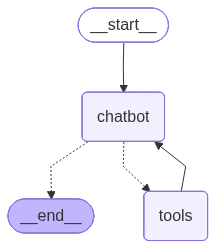

In [25]:
graph_builder = StateGraph(ChatbotState)
# graph_builder.add_node("rag", rag_node)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools))
graph_builder.add_edge(START, "chatbot")
# graph_builder.add_edge("chatbot", "rag")
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
graph

#### Run graph

In [26]:
def stream_graph_updates(user_input: str):
    # Memory
    config = {"configurable": {"thread_id": "1"}}
    for event in graph.stream(
        {"messages": [{"role": "user", 
                       "content": user_input}]}, config):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        print("User: " + user_input)
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "Tell me what you can do for me."
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: Is Lattice parsing used in LinearDesign's underlying optimisation algorithm?
Assistant: 
Assistant: {'query': "Is Lattice parsing used in LinearDesign's underlying optimisation algorithm?", 'result': 'Yes, according to the text, lattice parsing is used in LinearDesign\'s underlying optimization algorithm. The text states that LinearDesign "adapts the classical concept of lattice parsing" and "reduces the mRNA design problem to the classical computational linguistics problem of lattice parsing." It also mentions that they "simply adapt the classical lattice parsing to mRNA design" using their LinearDesign algorithm.', 'source_documents': [Document(id='07a6e6b4-435f-4c17-af8d-1bbe0df83029', metadata={'producer': '', 'creator': 'Springer', 'creationdate': '2023-09-02T09:04:03+05:30', 'source': 'example_pdf/s41586-023-06127-z-1.pdf', 'file_path': 'example_pdf/s41586-023-06127-z-1.pdf', 'total_pages': 28, 'format': 'PDF 1.4', 'title': 'Algorithm for optimized mRNA design improves stab